In [15]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from colorcet.plotting import swatch
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.patches as mpatches


sns.set_style("darkgrid")

In [3]:
filename = ""
sheet_name = ""

df = pd.read_excel(filename, sheet_name)

In [4]:
# Drop columns ending with "_male" or "_female"
df = df.drop(df.filter(like="_male", axis=1).columns, axis=1)
df = df.drop(df.filter(like="_female", axis=1).columns, axis=1)

# Remove "_total" from colnames
df = df.rename(
    columns={col: col.split("_")[0] for col in df.columns if col.endswith("_total")}
)

In [5]:
# pseudonymize and rename locations
location_pseudonyms = {
    "": "Site 1",
    "": "Site 2",
    "": "Site 3",
    "": "Site 4",
    "": "Site 5",
    "": "Site 6",
}
desired_order = ["entity", "Site 6", "Site 5", "Site 4", "Site 3", "Site 2", "Site 1"]

df = df.rename(columns=location_pseudonyms)[desired_order]

In [6]:
# calculate relative tumor cases per location and entity in %
for location in [col for col in df.columns if col.startswith("Site")]:
    new_col = location + " [%]"
    if new_col not in df.columns:
        df[new_col] = (df[location] / df[location].sum() * 100).round(1)

In [7]:
# melt down "site 1, 2, 3..." to a "site" col with values as second column "abs_cases"
sites_abs = [col for col in df.columns if col.startswith("Site") and col[-1].isdigit()]

df_melt_abs = pd.melt(
    df,
    id_vars=["entity"],
    value_vars=sites_abs,
    var_name="site",
    value_name="abs_cases",
)

In [8]:
# melt down "site 1 [%], 2 [%]..." to a "site [%]" col with values as another volumn "%_cases"
sites_rel = [
    col for col in df.columns if col.startswith("Site") and not col[-1].isdigit()
]

df_melt_rel = pd.melt(
    df,
    id_vars=["entity"],
    value_vars=sites_rel,
    var_name="site %",
    value_name="%_cases",
)

In [9]:
# join both melted dfs
df_melt = pd.concat([df_melt_abs, df_melt_rel], axis=1)
# drop site % col
df_melt = df_melt.drop(["site %"], axis=1)
# drop second entity col
df_melt = df_melt.loc[:, ~df_melt.columns.duplicated()].copy()

In [10]:
pivoted_dfs = []

# Get the list of unique sites
unique_sites = df_melt["site"].unique()

# Loop through each site, filter the dataframe, pivot and sort
for site in unique_sites:
    # Filter the dataframe by the current site
    df_site = df_melt[df_melt["site"] == site]

    # Pivot the filtered dataframe
    df_pivot_site = df_site.pivot(index="site", columns="entity", values="%_cases")

    # Sort the pivoted dataframe by descending order individually for each site
    df_pivot_site = df_pivot_site.reindex(
        df_pivot_site.mean().sort_values(ascending=False).index, axis=1
    )

    # Append the pivoted dataframe to the list
    pivoted_dfs.append(df_pivot_site)

In [11]:
def plot_df(data_df, custom_colors):
    fig, ax = plt.subplots(figsize=(30, 10))

    # Create custom colormap
    custom_cmap = plt.cm.colors.ListedColormap(custom_colors)

    data_df.plot(
        kind="barh", stacked=True, ax=ax, width=0.8, cmap=custom_cmap
    )  # Use the custom colormap here

    for c in ax.containers:
        labels = [f"{v.get_width():.1f}" if v.get_width() > 2.0 else "" for v in c]
        ax.bar_label(
            c,
            label_type="center",
            labels=labels,
            size=26,
            fontweight="bold",
            color="white",
        )

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    ax.set_xticks(range(0, 101, 20))
    ax.set_xticklabels([f"{x}%" for x in range(0, 101, 20)])

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=4,
        fontsize=20,
    )

    ax.tick_params(axis="x", labelsize=33)
    ax.tick_params(axis="y", labelsize=33)

    ax.set_ylabel("")

    plt.show()

In [12]:
custom_colors = [
    "#e6194b",
    "#FF8C00",
    "#3cb44b",
    "#0082c8",
    "#ffe119",
    "#6e3a7d",
    "#46f0f0",
    "#b722af",
    "#d2f53c",
    "#FF69B4",
    "#008080",
    "#e6beff",
    "#aa6e28",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#FFA07A",
    "#3288bd",
    "#808080",
    "#6A5ACD",
    "#006400",
    "#e6194b",
    "#9e4242",
]

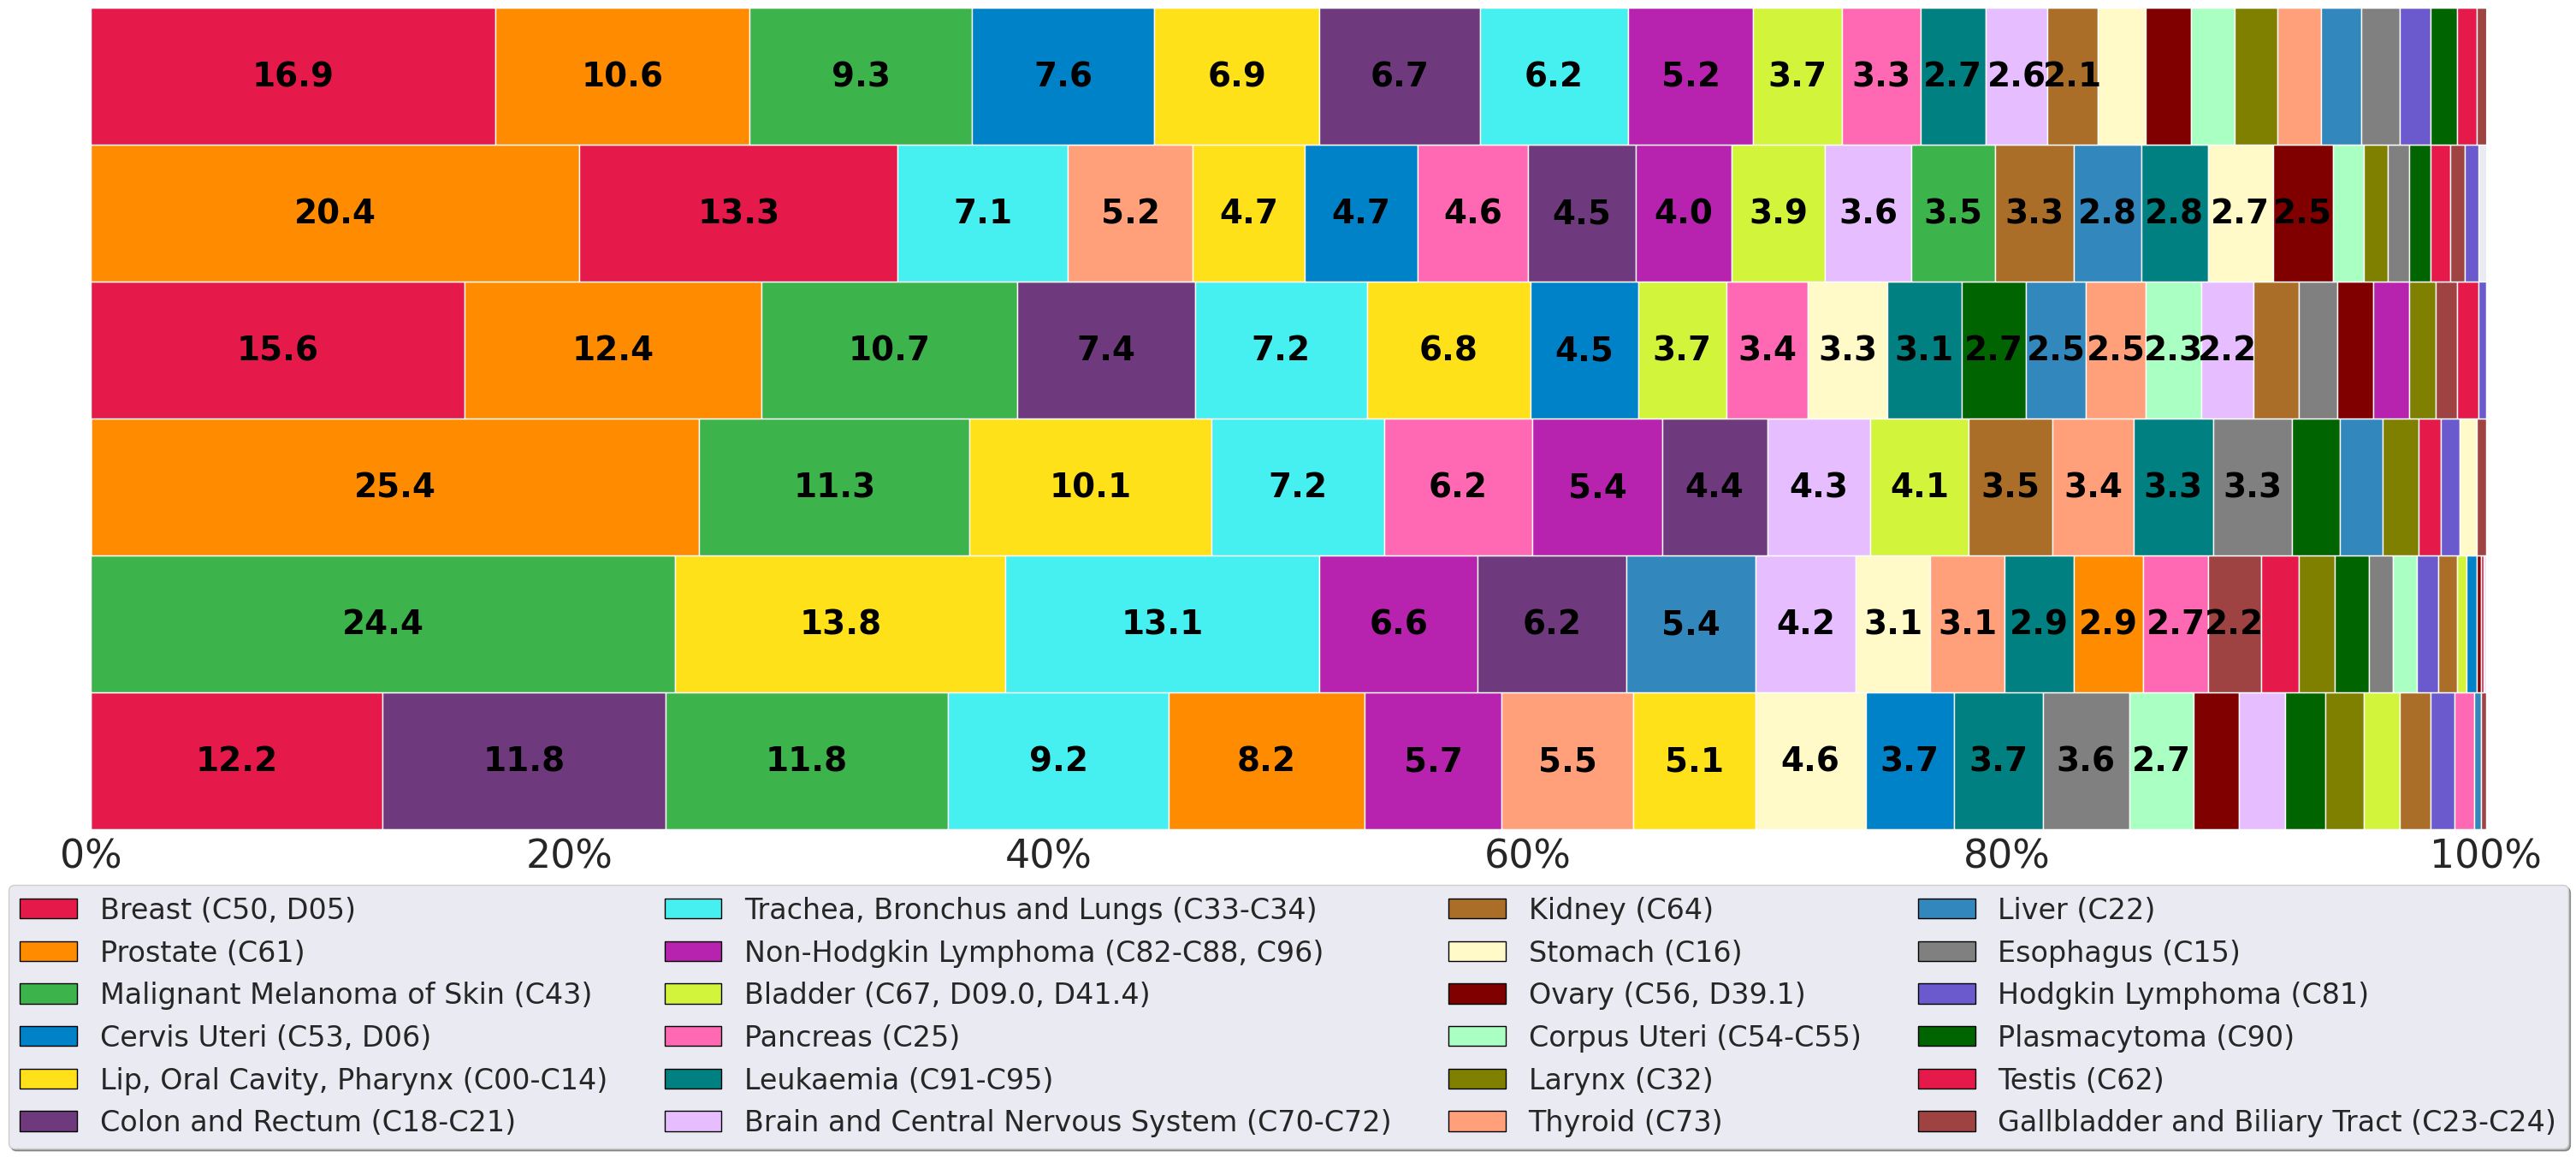

In [16]:
def plot_all_sites(data_dfs):
    fig, ax = plt.subplots(figsize=(35, 12))

    unique_entities = data_dfs[-1].columns.tolist()

    # Create a dictionary to map each entity to a color
    color_dict = {
        entity: custom_colors[i % len(custom_colors)]
        for i, entity in enumerate(unique_entities)
    }

    site_names = [f"Site {i + 1}" for i in range(len(data_dfs))]
    bar_positions = list(range(len(data_dfs)))

    for i, data_df in enumerate(data_dfs):
        data_df.plot(
            kind="barh",
            stacked=True,
            ax=ax,
            width=0.8,
            color=[color_dict[col] for col in data_df.columns],
            position=i,
        )  # Using position=i for proper alignment

    for c in ax.containers:
        labels = [f"{v.get_width():.1f}" if v.get_width() > 2.0 else "" for v in c]
        ax.bar_label(
            c,
            label_type="center",
            labels=labels,
            size=28,
            fontweight="bold",
            color="black",
        )

    # Adjust the position and size of the plot to ensure proper alignment
    ax.set_position([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]

    ax.set_xticks(range(0, 101, 20))
    ax.set_xticklabels([f"{x}%" for x in range(0, 101, 20)])

    # Adjust the legend to fit the plot
    # legend_elements = [plt.Line2D([0], [0], color=color_dict[entity], lw=16, label=entity) for entity in unique_entities]
    legend_elements = [
        mpatches.Patch(
            facecolor=color_dict[entity], edgecolor="black", linewidth=1, label=entity
        )
        for entity in unique_entities
    ]
    ax.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=4,
        fontsize=24,
    )

    ax.tick_params(axis="x", labelsize=33)
    ax.tick_params(axis="y", labelsize=33)

    ax.set_ylabel("")

    for label in ax.get_yticklabels():
        label.set_y(1.0)

    # Set y-ticks and add site names
    bar_positions_adjusted = [p + 0.4 for p in bar_positions]
    ax.set_yticks(bar_positions_adjusted)
    # ax.set_yticklabels(site_names, fontsize=33)  # Add site names as labels

    ax.set_ylim(-4, len(data_dfs) - 5.2)
    ax.set_xlim(0, 100)

    ax.invert_yaxis()

    plt.show()


plot_all_sites(pivoted_dfs)